In [2]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE


In [3]:
# ---------- Load and Clean ----------
def load_and_clean(path):
    df = pd.read_csv(path)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df.dropna()

# Load datasets
benign = pd.concat([
    load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/Benign.csv"),
    load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/Benign1.csv"),
    load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/Benign2.csv"),
    load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/Benign3.csv")
], ignore_index=True)

# Attack datasets
sqlInj = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/SqlInjection.csv")
uploading = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/Uploading_Attack.csv")
portscan = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/Recon-PortScan.csv")
Backdoor_Malware = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/Backdoor_Malware.csv")
BrowserHijacking = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/BrowserHijacking.csv")
DDoS_SlowLoris = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/DDoS-SlowLoris.csv")
DNS_Spoofing = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/DNS_Spoofing.csv")
Recon_OSScan = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/Recon-OSScan.csv")
VulnerabilityScan = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/VulnerabilityScan.csv")
XSS = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/XSS.csv")

common_cols = list(set(benign.columns) & set(uploading.columns) & set(sqlInj.columns) & set(portscan.columns) &  set(Backdoor_Malware.columns) & set(BrowserHijacking.columns) & set(DDoS_SlowLoris.columns)  &  set(Recon_OSScan.columns) & set(VulnerabilityScan.columns)  &  set(XSS.columns) )
if "Label" in common_cols:
    common_cols.remove("Label")



When to use fit_transform() vs. transform()

fit_transform()	Training data (e.g., benign)	Learns the transformation (fit) and then applies it
transform()	Test/attack/other datasets	Just applies the learned transformation — no learning happens

In [4]:
X_benign = benign[common_cols] # get only common_cols from dataset cvs
X_upload = uploading[common_cols]
X_sqlInj = sqlInj[common_cols]
X_portscan = portscan[common_cols]

X_Backdoor_Malware = Backdoor_Malware[common_cols]
X_BrowserHijacking = BrowserHijacking[common_cols]
X_DDoS_SlowLoris = DDoS_SlowLoris[common_cols]
X_DNS_Spoofing = DNS_Spoofing[common_cols]
X_Recon_OSScan = Recon_OSScan[common_cols] 
X_VulnerabilityScan = VulnerabilityScan[common_cols]
X_XSS = XSS[common_cols]



scaler = StandardScaler()
X_benign_scaled = scaler.fit_transform(X_benign)

X_upload_scaled = scaler.transform(X_upload)
X_sqlInj_scaled = scaler.transform(X_sqlInj)
X_portscan_scaled = scaler.transform(X_portscan)

X_Backdoor_Malware_scaled = scaler.transform(X_Backdoor_Malware)
X_BrowserHijacking_scaled = scaler.transform(X_BrowserHijacking)
X_DDoS_SlowLoris_scaled = scaler.transform(X_DDoS_SlowLoris)
X_DNS_Spoofing_scaled = scaler.transform(X_DNS_Spoofing)
X_Recon_OSScan_scaled = scaler.transform(X_Recon_OSScan)

# Clip all values to a range, e.g., [-1e10, 1e10]
X_VulnerabilityScan = X_VulnerabilityScan.clip(-1e10, 1e10) #If your dataset has legitimate but extreme values, you can clip them to a reasonable range:
# Also replace inf just in case
X_VulnerabilityScan.replace([np.inf, -np.inf], np.nan, inplace=True)
X_VulnerabilityScan.dropna(inplace=True)

X_VulnerabilityScan_scaled = scaler.transform(X_VulnerabilityScan)

X_XSS_scaled = scaler.transform(X_XSS)


In [5]:
import torch

# Convert NumPy arrays to float32 tensors
X_benign_tensor = torch.tensor(X_benign_scaled, dtype=torch.float32)
X_upload_tensor = torch.tensor(X_upload_scaled, dtype=torch.float32)
X_sqlInj_tensor = torch.tensor(X_sqlInj_scaled, dtype=torch.float32)
X_portscan_tensor = torch.tensor(X_portscan_scaled, dtype=torch.float32)


X_Backdoor_Malware_tensor = torch.tensor(X_Backdoor_Malware_scaled, dtype=torch.float32)
X_BrowserHijacking_tensor = torch.tensor(X_BrowserHijacking_scaled, dtype=torch.float32)
X_DDoS_SlowLoris_tensor = torch.tensor(X_DDoS_SlowLoris_scaled, dtype=torch.float32)
X_DNS_Spoofing_tensor = torch.tensor(X_DNS_Spoofing_scaled, dtype=torch.float32)
X_Recon_OSScan_tensor = torch.tensor(X_Recon_OSScan_scaled, dtype=torch.float32)
X_VulnerabilityScan_tensor = torch.tensor(X_VulnerabilityScan_scaled, dtype=torch.float32)
X_XSS_tensor = torch.tensor(X_XSS_scaled, dtype=torch.float32)


Epoch 1, Loss: 0.028668
Epoch 2, Loss: 0.004791
Epoch 3, Loss: 0.003256
Epoch 4, Loss: 0.002480
Epoch 5, Loss: 0.002132
Epoch 6, Loss: 0.001823
Epoch 7, Loss: 0.001662
Epoch 8, Loss: 0.001465
Epoch 9, Loss: 0.001350
Epoch 10, Loss: 0.001270
Epoch 11, Loss: 0.001233
Epoch 12, Loss: 0.001137
Epoch 13, Loss: 0.001054
Epoch 14, Loss: 0.001037
Epoch 15, Loss: 0.001010
Epoch 16, Loss: 0.001008
Epoch 17, Loss: 0.000941
Epoch 18, Loss: 0.000917
Epoch 19, Loss: 0.000932
Epoch 20, Loss: 0.000892


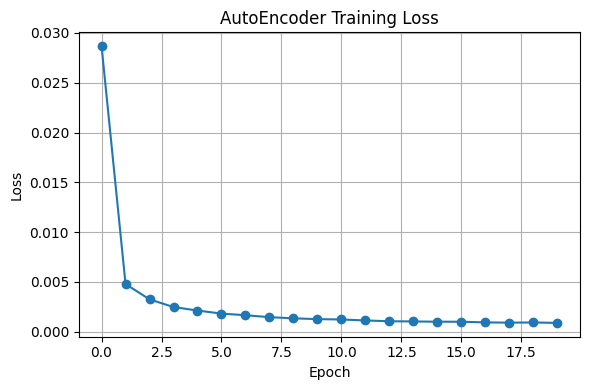


=== Evaluation Metrics by Attack Type ===

Attack Type             Threshold         F1  Precision     Recall
sqlInj                   0.000062     0.9999     1.0000     0.9998


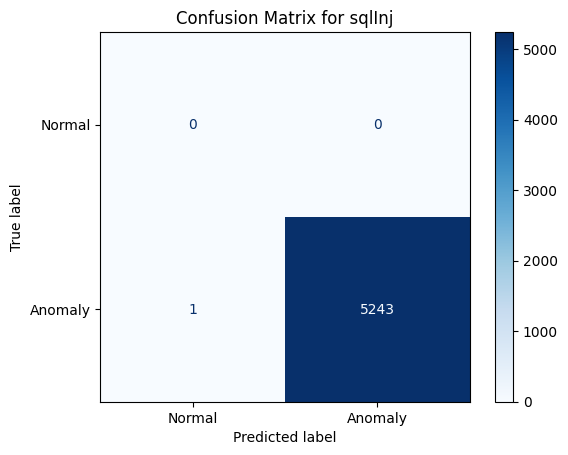

portscan                 0.000046     1.0000     1.0000     1.0000


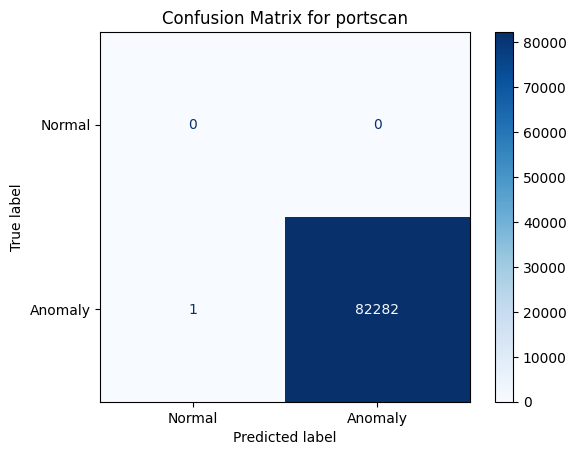

XSS                      0.000059     0.9999     1.0000     0.9997


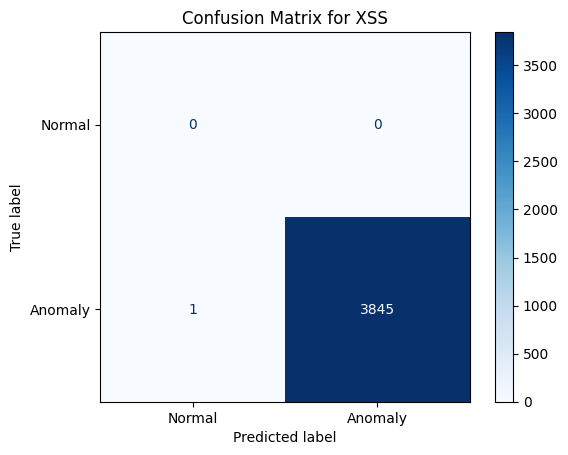

DDoS                     0.000138     1.0000     1.0000     1.0000


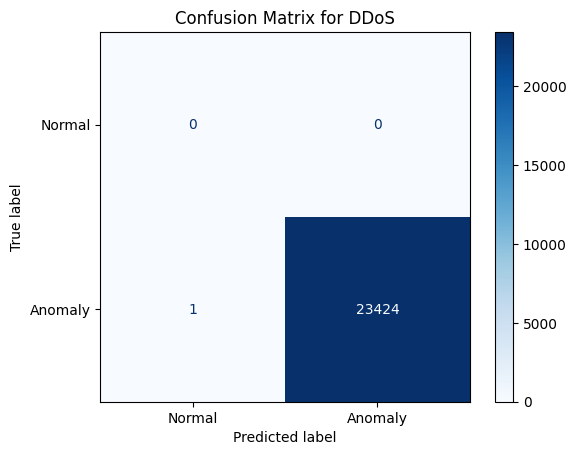

BrowserHijacking         0.000052     0.9999     1.0000     0.9998


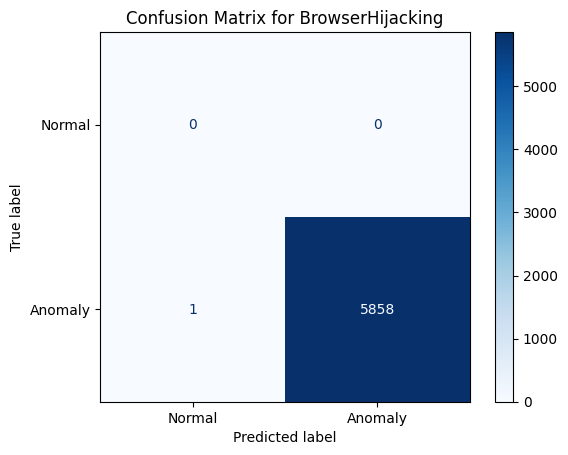

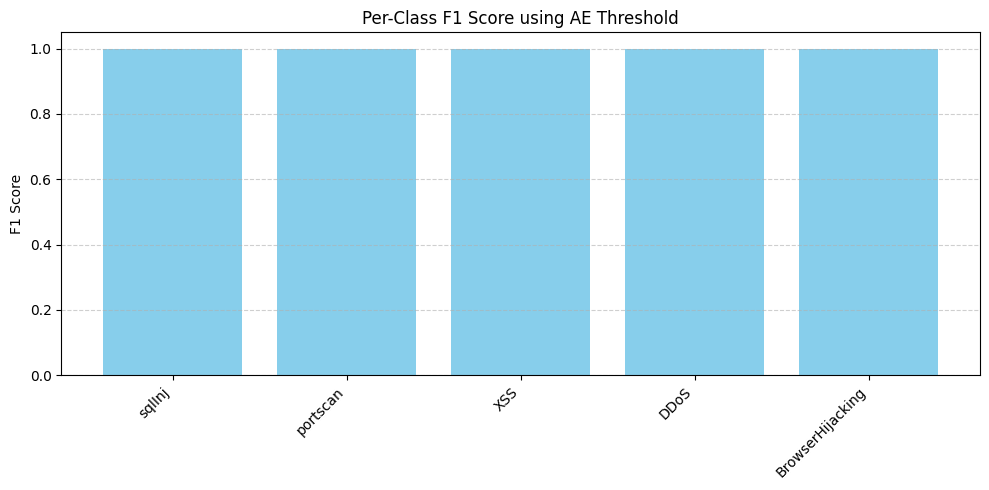

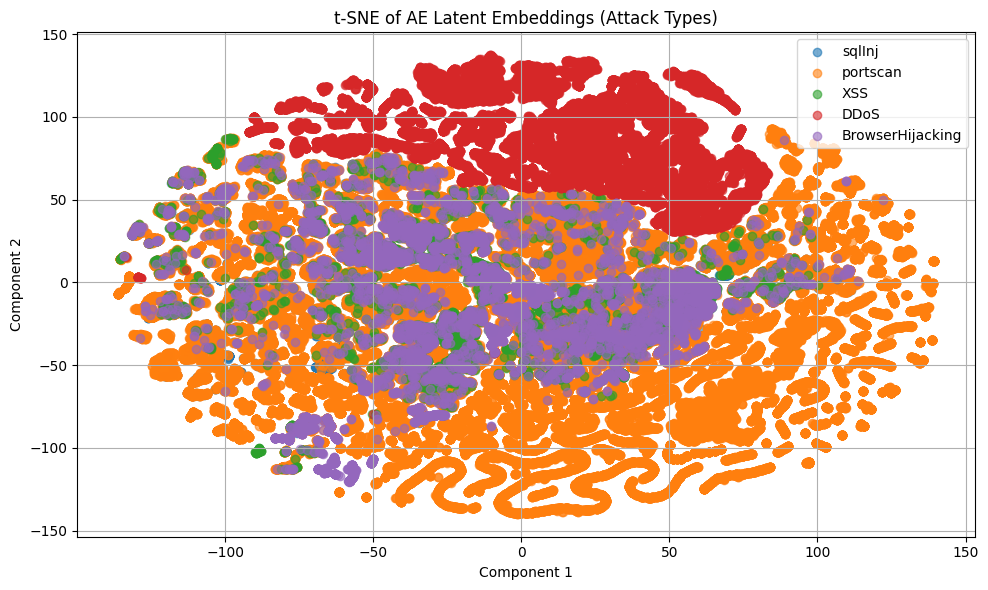

({'sqlInj': 0.9999046438447602,
  'portscan': 0.9999939233737429,
  'XSS': 0.9998699778962423,
  'DDoS': 0.9999786548272108,
  'BrowserHijacking': 0.9999146539216524},
 {'sqlInj': 1.0,
  'portscan': 1.0,
  'XSS': 1.0,
  'DDoS': 1.0,
  'BrowserHijacking': 1.0},
 {'sqlInj': 0.9998093058733791,
  'portscan': 0.9999878468213361,
  'XSS': 0.999739989599584,
  'DDoS': 0.999957310565635,
  'BrowserHijacking': 0.9998293224099676})

In [6]:
class AEWithAttention(nn.Module):
    def __init__(self, input_dim, bottleneck_dim=16):
        super().__init__()
        self.feature_attention = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, input_dim),
            nn.Sigmoid()
        )
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, bottleneck_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        attn_weights = self.feature_attention(x)
        x_weighted = x * attn_weights
        encoded = self.encoder(x_weighted)
        decoded = self.decoder(encoded)
        return decoded, encoded


def train_autoencoder(model, data, device, epochs=20):
    model.to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    loader = DataLoader(TensorDataset(torch.tensor(data, dtype=torch.float32)), batch_size=128, shuffle=True)
    train_losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for x_batch, in loader:
            x_batch = x_batch.to(device)
            optimizer.zero_grad()
            recon, _ = model(x_batch)
            loss = criterion(recon, x_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(loader))
        print(f"Epoch {epoch+1}, Loss: {train_losses[-1]:.6f}")

    # Plot training loss
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, marker='o', linestyle='-')
    plt.title("AutoEncoder Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model


def extract_features(model, X_scaled, device):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
        recon, embed = model(X_tensor)
        loss = torch.mean((X_tensor - recon) ** 2, dim=1, keepdim=True)
        log_loss = torch.log1p(loss)
        combined = torch.cat([embed, loss, log_loss], dim=1).cpu().numpy()
    return combined, loss.cpu().numpy()


def find_best_threshold(y_true, loss_vector):
    thresholds = np.linspace(min(loss_vector), max(loss_vector), 100)
    best_thresh = 0
    best_f1 = 0
    for thresh in thresholds:
        y_pred = (loss_vector > thresh).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    return best_thresh, best_f1


def detect_anomalies(loss_vector, threshold):
    return (loss_vector > threshold).astype(int)  # 1 = anomaly, 0 = normal


def evaluate_attack_types(model, attack_dict, device):
    f1_scores = {}
    precisions = {}
    recalls = {}
    all_embeds = []
    all_labels = []
    attack_names = list(attack_dict.keys())

    print("\n=== Evaluation Metrics by Attack Type ===")
    print("\n{:<20s} {:>12s} {:>10s} {:>10s} {:>10s}".format("Attack Type", "Threshold", "F1", "Precision", "Recall"))
    print("="*65)

    for idx, (name, X_scaled) in enumerate(attack_dict.items()):
        combined, loss_vec = extract_features(model, X_scaled, device)
        embed = combined[:, :model.encoder[-1].out_features]  # Get only bottleneck vector

        # Store for t-SNE
        all_embeds.append(embed)
        all_labels.extend([idx] * len(embed))

        y_true = np.ones(len(loss_vec))  # all are attacks
        threshold, best_f1 = find_best_threshold(y_true, loss_vec)
        y_pred = detect_anomalies(loss_vec, threshold)

        f1 = f1_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred)

        f1_scores[name] = f1
        precisions[name] = prec
        recalls[name] = rec

        print(f"{name:20} {threshold.item():12.6f} {f1:10.4f} {prec:10.4f} {rec:10.4f}")

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
        disp.plot(cmap='Blues')
        plt.title(f"Confusion Matrix for {name}")
        plt.grid(False)
        plt.show()

    # F1 Bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(f1_scores.keys(), f1_scores.values(), color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("F1 Score")
    plt.title("Per-Class F1 Score using AE Threshold")
    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.show()

    # t-SNE Visualization
    all_embeds = np.vstack(all_embeds)
    tsne = TSNE(n_components=2, random_state=42)
    tsne_proj = tsne.fit_transform(all_embeds)

    plt.figure(figsize=(10, 6))
    for i, label in enumerate(attack_names):
        plt.scatter(tsne_proj[np.array(all_labels) == i, 0], tsne_proj[np.array(all_labels) == i, 1], label=label, alpha=0.6)

    plt.legend()
    plt.title("t-SNE of AE Latent Embeddings (Attack Types)")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return f1_scores, precisions, recalls


# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AEWithAttention(input_dim=X_benign.shape[1])
trained_model = train_autoencoder(model, X_benign_scaled, device)
attack_dict = {
    "sqlInj": X_sqlInj_scaled,
    "portscan": X_portscan_scaled,
    "XSS": X_XSS_scaled,
    "DDoS": X_DDoS_SlowLoris_scaled,
    "BrowserHijacking": X_BrowserHijacking_scaled
}
evaluate_attack_types(trained_model, attack_dict, device)
